In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

imputer

In [3]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor



# Initialize KNNImputer
imputer = IterativeImputer(estimator= 
    RandomForestRegressor(
        # We tuned the hyperparameters of the RandomForestRegressor to get a good
        # enough predictive performance for a restricted execution time.
        n_estimators=4,
        max_depth=10,
        bootstrap=True,
        max_samples=0.5,
        n_jobs=2,
        random_state=0,
    )
)

In [4]:

from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold

# Setting up the cross-validation scheme
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Scorer for cross-validation
f1_scorer = make_scorer(f1_score, average='weighted')

In [5]:


from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


best_params_rf = {'class_weight': 'balanced_subsample',
                    'max_depth': 10,
                    'max_features': 'sqrt',
                    'min_samples_leaf': 2,
                    'min_samples_split': 2,
                    'n_estimators': 100}

rf = RandomForestClassifier(**best_params_rf, random_state=42, n_jobs=-1)
gbrt = GradientBoostingClassifier(max_depth=10, 
                                      max_features='sqrt',
                                        min_samples_leaf=2,
                                        min_samples_split=2, 
                                        learning_rate=1,
                                        n_estimators=100,
                                        # n_iter_no_change=20,
                                        random_state=42
                                        )

best_params_svm = {'C': 3, 'gamma': 0.1, 'kernel': 'rbf'}
svm = SVC(**best_params_svm,random_state=42)

best_params_knn = {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
knn=KNeighborsClassifier(**best_params_knn)


Stacking classifier

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

estimators = [
    ('rf', rf),
    ('gbrt', gbrt),
    ('svm', svm),
    ('knn', knn)
]


stacking_clf = StackingClassifier(estimators=estimators, 
                                  final_estimator=LogisticRegression(),
                                  n_jobs=-1)


pipeline = Pipeline([
    ('imputer', imputer),
    ('scaler',StandardScaler()),   
    ('stacking', stacking_clf) 
])



load data

In [7]:
from sklearn.model_selection import train_test_split

data = pd.read_excel('../data/Gestational Diabetic Dat Set.xlsx')
data=data.drop('Case Number',axis=1)

data['OGTT']=np.log(data['OGTT'])

X = data.drop('Class Label(GDM /Non GDM)', axis=1) 
y = data['Class Label(GDM /Non GDM)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train

In [8]:
# Perform 5-fold cross-validation and calculate F1 score for each fold on the training set
train_f1_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')

# Train the model on the entire training set
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred_test = pipeline.predict(X_test)

# Calculate F1 score on the test set
test_f1_score = f1_score(y_test, y_pred_test)

print(f"Train F1 Score: {train_f1_scores.mean()}")
print(f"Test F1 Score: {test_f1_score}")

c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.w

Train F1 Score: 0.9655899710656655
Test F1 Score: 0.963106796116505


Precision recall analysis

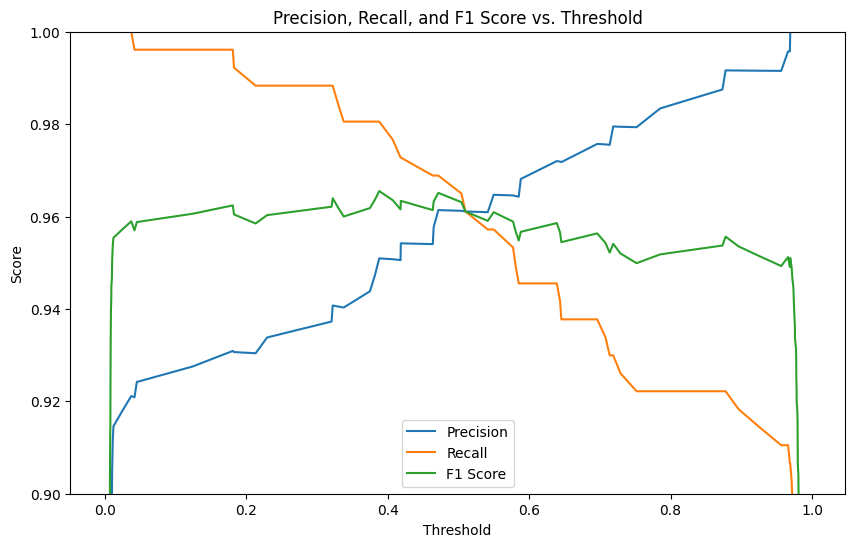

In [9]:
from sklearn.metrics import precision_recall_curve, f1_score

# Generate model probabilities
y_scores = pipeline.predict_proba(X_test)[:, 1]

# Calculate precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])

# Handle the case where precision and recall are both zero (F1 is undefined)
f1_scores = np.nan_to_num(f1_scores)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision')  # Exclude the last value
plt.plot(thresholds, recall[:-1], label='Recall')  # Exclude the last value
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend()
plt.ylim(0.9,1)
plt.savefig('../plots/precision_recall.png')
plt.show()

In [10]:
from sklearn.metrics import accuracy_score

y_pred_train= pipeline.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)


print(f'train accuracy is: {accuracy_train}')
print(f'test accuracy is: {accuracy_test}')

train accuracy is: 1.0
test accuracy is: 0.9730496453900709
